In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# import seaborn as sns
import os

In [2]:
os.chdir('/Users/zhangle/百度云同步盘/工作/measles')
measles = pd.read_excel('measles.xlsx')

## 全国麻疹

In [3]:
import statsmodels.api as sm
quanguo = measles.ix[measles.Area == '全国',:]
quanguo.index = pd.Index(sm.tsa.datetools.dates_from_range('1950','2014'))
quanguo.head()

,Area_code,Area,Year,No_of_cases,No_of_deaths,Incidence_rate,Death_rate
1950-12-31,0,全国,1950,132167,8534,44.08,2.85
1951-12-31,0,全国,1951,866686,44781,178.48,9.22
1952-12-31,0,全国,1952,1040207,41586,189.44,7.57
1953-12-31,0,全国,1953,1806834,50640,320.16,8.97
1954-12-31,0,全国,1954,2071466,36569,355.81,6.28


## 一、稳定性检测
### 1. 绘制滚动统计：我们可以绘制移动平均数和移动方差，观察它是否随着时间变化。

In [4]:
def rolling_statistics(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=5,center=False).mean()
    rolstd = timeseries.rolling(window=5,center=False).std()
    #Plot rolling statistics:
    fig = plt.figure(figsize=(11, 7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [5]:
# rolling_statistics(quanguo['Incidence_rate'])

### 2. ADF检验：这是一种检查数据稳定性的统计测试。
无效假设：时间序列是不稳定的。
测试结果由测试统计量和一些置信区间的临界值组成。如果“测试统计量”少于“临界值”，我们可以拒绝无效假设，并认为序列是稳定的。
或者根据前面提高的p值检验，如果p值小于显著性水平，我们可以拒绝无效假设，认为序列稳定。

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    rolling_statistics(timeseries) #绘图
    print('Results of Augment Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

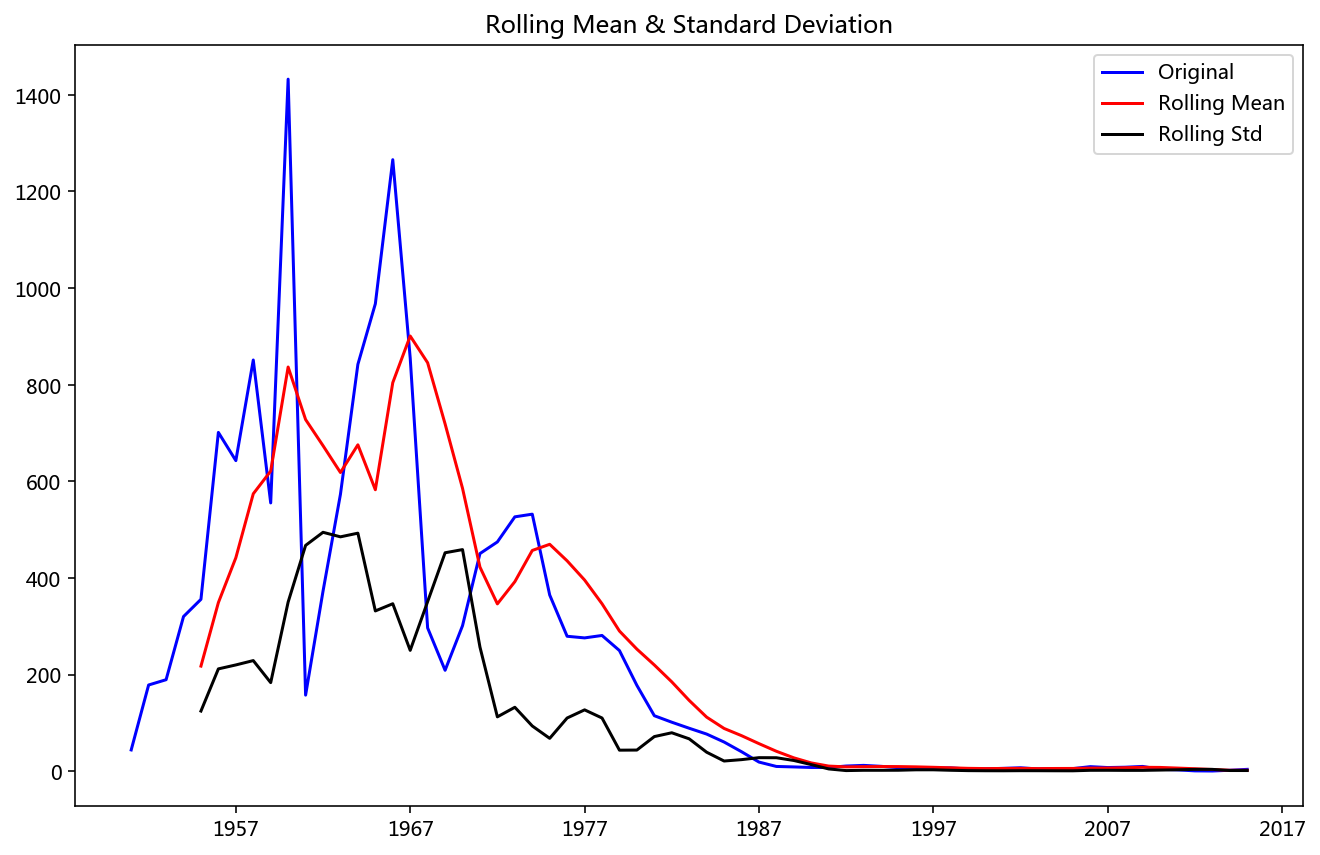

Results of Augment Dickey-Fuller Test:
Test Statistic                 -3.482302
p-value                         0.008453
#Lags Used                     11.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


In [7]:
adf_test(quanguo['Incidence_rate'])

#### 解释上述结果
    Test statistic：代表检验统计量
    p-value：代表p值检验的概率
    Lags used：使用的滞后k，autolag=AIC时会自动选择滞后
    Number of Observations Used：样本数量
    Critical Value(5%) : 显著性水平为5%的临界值
    
    假设是存在单位根，即不平稳；
    显著性水平，1%：严格拒绝原假设；5%：拒绝原假设，10%类推。
    看P值和显著性水平a的大小，p值越小，小于显著性水平的话，就拒绝原假设，认为序列是平稳的；大于的话，不能拒绝，认为是不平稳的
        p=0.008<0.01 平稳
    看检验统计量和临界值，检验统计量小于临界值的话，就拒绝原假设，认为序列是平稳的；大于的话，不能拒绝，认为是不平稳的
        统计量-3.48 >  1%临界值-3.56  不平稳
        统计量-3.48 <  5%临界值-2.92  平稳
        统计量-3.48 < 10%临界值-2.59  平稳


#### 先让我们弄明白是什么导致时间序列不稳定。两个主要原因。
    趋势----随着时间产生不同的平均值。举例：在飞机乘客这个案例中，我们看到总体上，飞机乘客的数量是在不断增长的。
    季节性----特定时间框架内的变化。举例：在特定的月份购买汽车的人数会有增加的趋势，因为车价上涨或者节假日到来。

## 二、平稳性处理

### 方法1 转换
对数变换

In [8]:
# 中文乱码设置
matplotlib.matplotlib_fname() # matplotlib配置文件位置
matplotlib.get_cachedir() # 删除~/.matplotlib/下的所有缓存文件
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

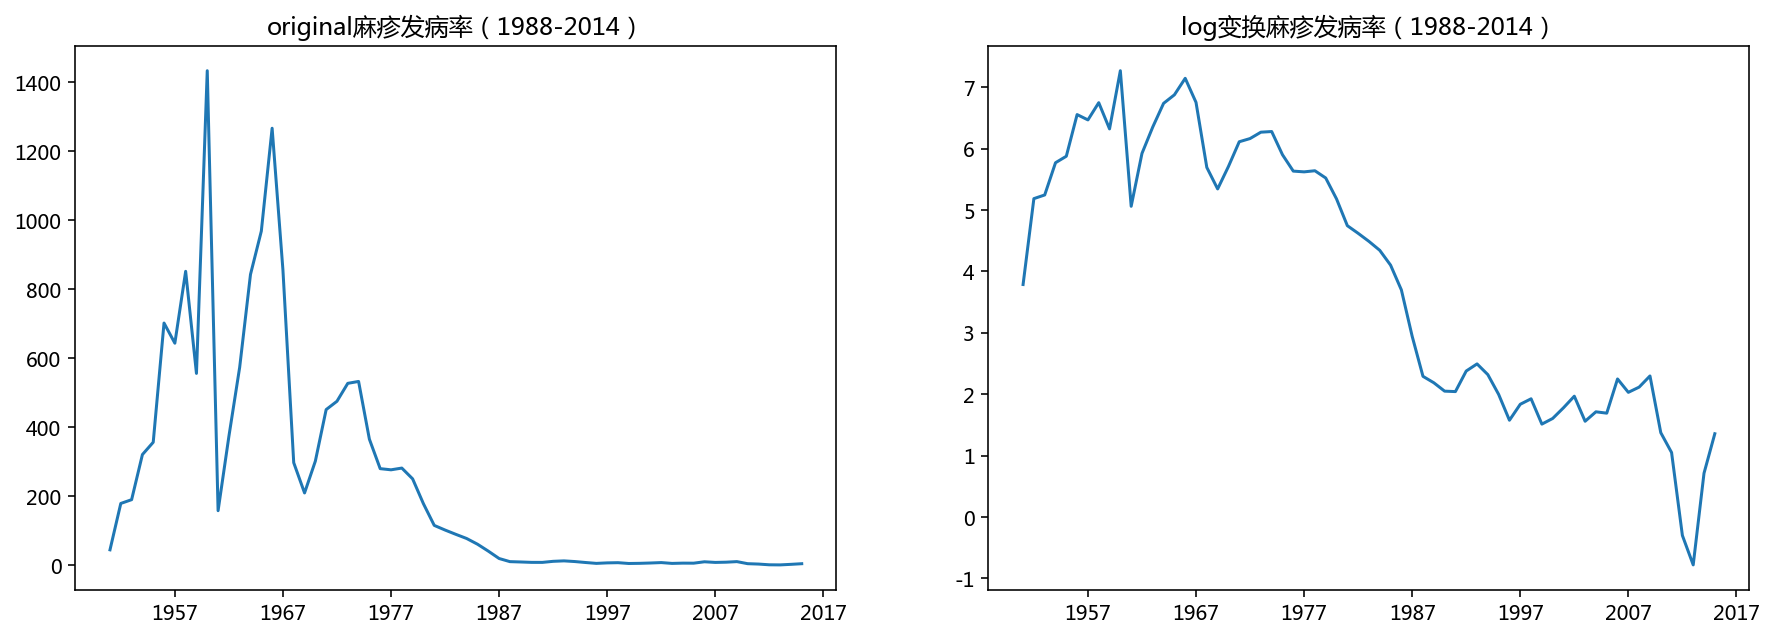

In [9]:
# help(Axes)
# 自1978年实施免疫规划以来，全国预防接种覆盖率一直保持在较高水平，
#并于1988、1990、1995年先后实现以省、县、乡为单位儿童国家免疫规划四苗接种率达到85%的普及儿童免疫目标

ts = quanguo['Incidence_rate']
ts_log = np.log(ts)

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(ts)
ax1.set_title('original麻疹发病率（1988-2014）')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(ts_log)
ax2.set_title('log变换麻疹发病率（1988-2014）')

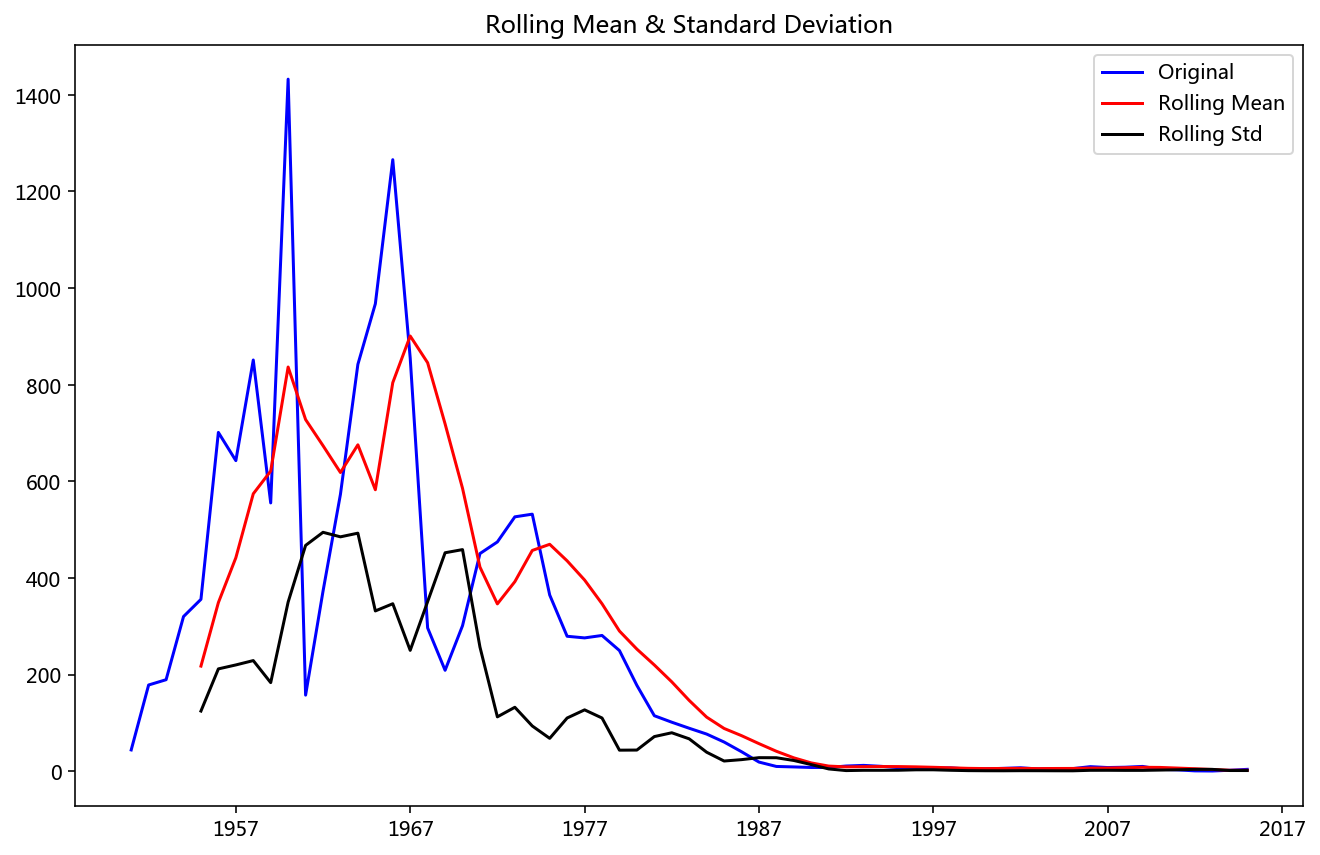

Results of Augment Dickey-Fuller Test:
Test Statistic                 -3.482302
p-value                         0.008453
#Lags Used                     11.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


In [90]:
adf_test(ts)

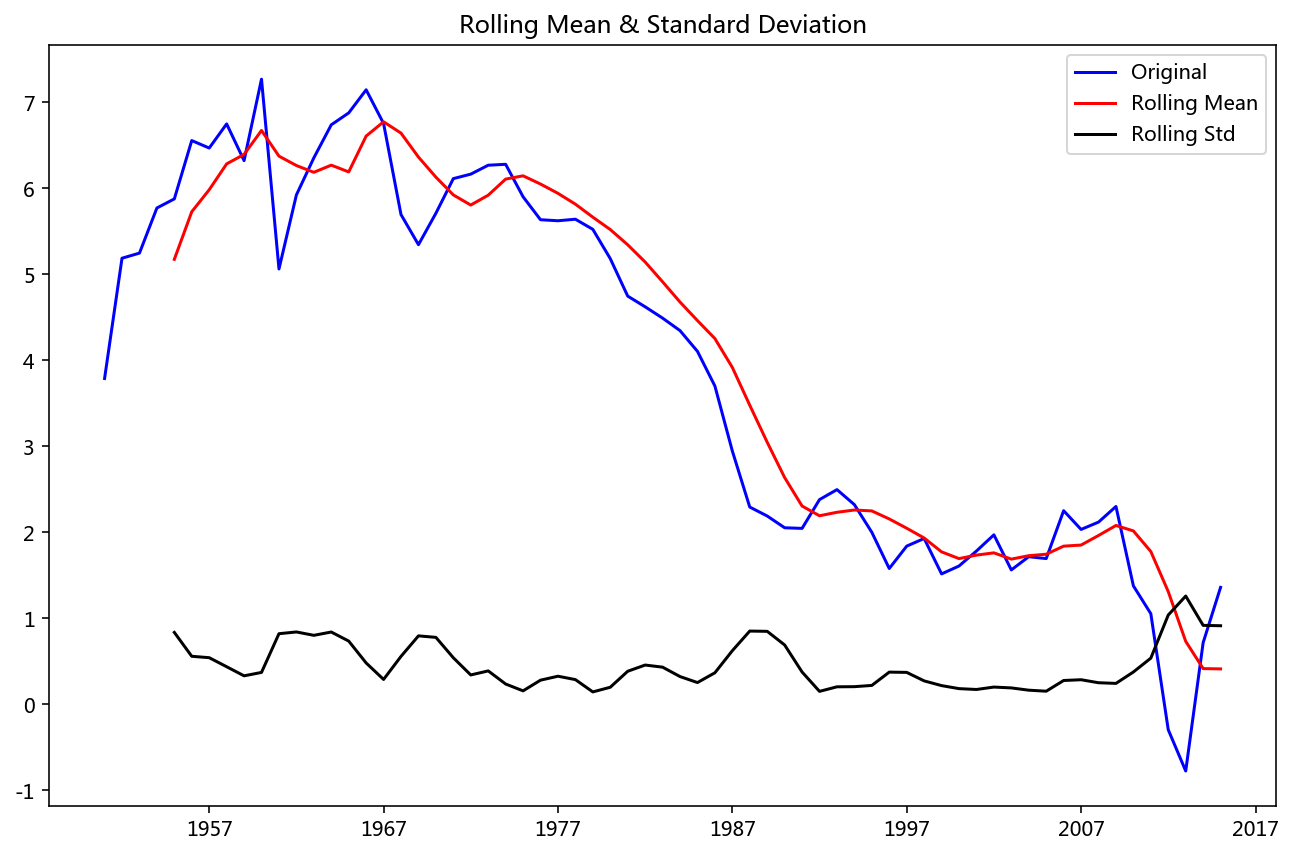

Results of Augment Dickey-Fuller Test:
Test Statistic                 -0.361498
p-value                         0.916332
#Lags Used                      4.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


In [91]:
adf_test(ts_log)

### 方法2 平滑
取滚动平均数平滑法。利用移动平均的方法来处理数据，可能可以用来处理#周期性因素#

### 方法3 差分
一般来说，非纯随机的时间序列经一阶差分或者二阶差分之后就会变得平稳。那差分几阶合理呢？我的观点是：在保证ADF检验的p<0.01的情况下，阶数越小越好，否则会带来样本减少、还原序列麻烦、预测困难的问题。

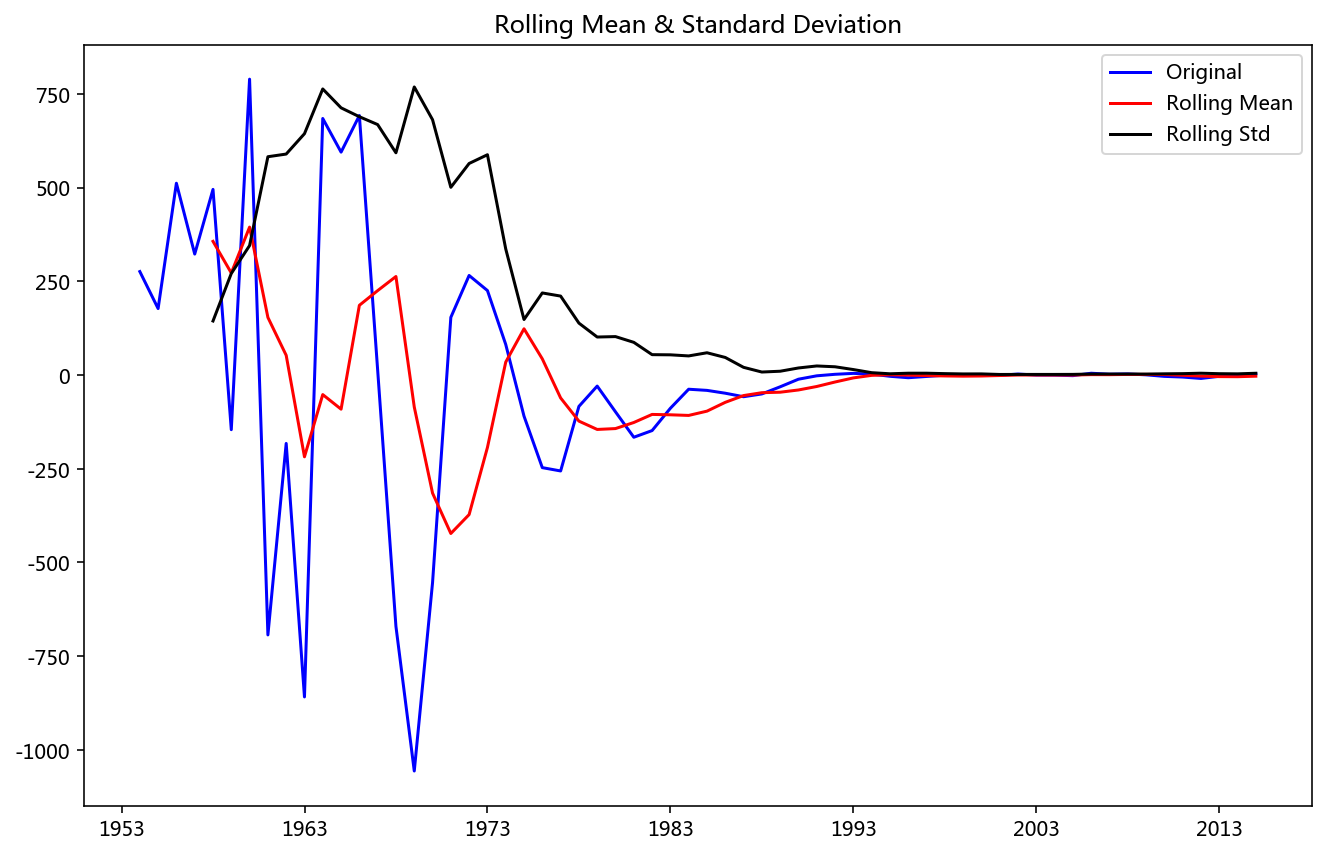

Results of Augment Dickey-Fuller Test:
Test Statistic                 -4.327526
p-value                         0.000398
#Lags Used                     10.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


In [10]:
# 不取对数 直接差分 需要1阶差分 p<0.05
ts_diff3 = ts - ts.shift(periods=3)
#diff_nan_index = ts_diff3.iloc[:1].index
#adf_test(ts_diff3.drop(diff_nan_index))
adf_test(ts_diff3.dropna(inplace=False))

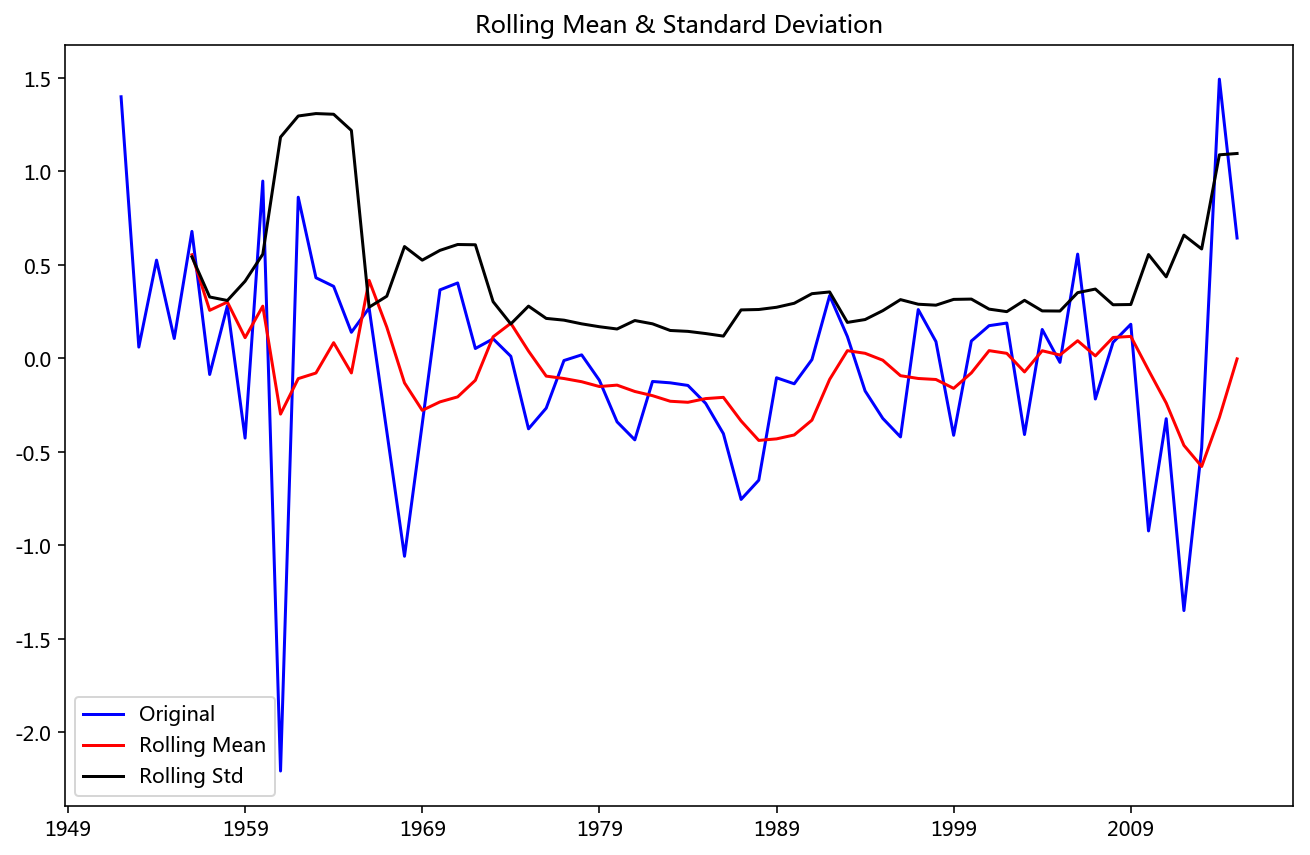

Results of Augment Dickey-Fuller Test:
Test Statistic                 -4.525188
p-value                         0.000177
#Lags Used                      3.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


In [95]:
# 取log做1阶差分 p<0.05
ts_log_diff1 = ts_log - ts_log.shift(periods=1)
adf_test(ts_log_diff1.dropna())
#diff_nan_index = ts_log_diff1.iloc[:1].index
#adf_test(ts_log_diff1.drop(diff_nan_index))

### 方法4 分解法
将时间序列分解成长期趋势、季节趋势和随机成分

## 三、建模

### 1.确定ARMA的阶数，ARMA(p,q)是AR(p)和MA(q)模型的组合，p和q的选择
#### 方法1 观察自相关图ACF和偏相关图PACF, 另一种方法是通过借助AIC、BIC统计量自动确定。

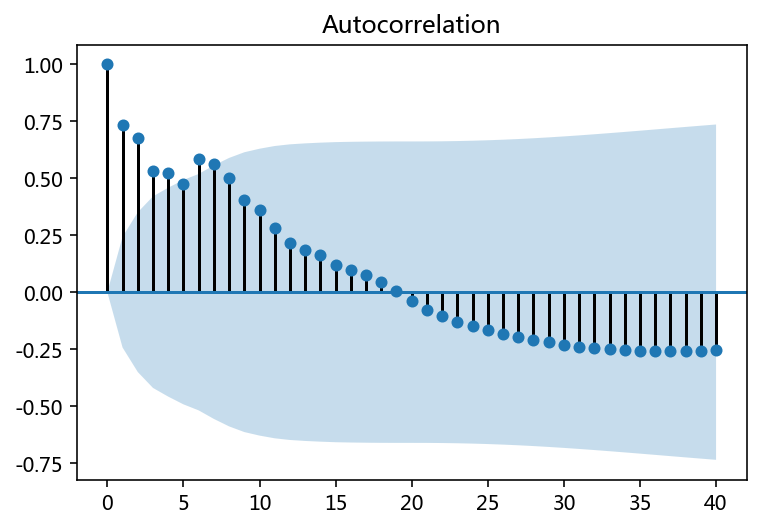

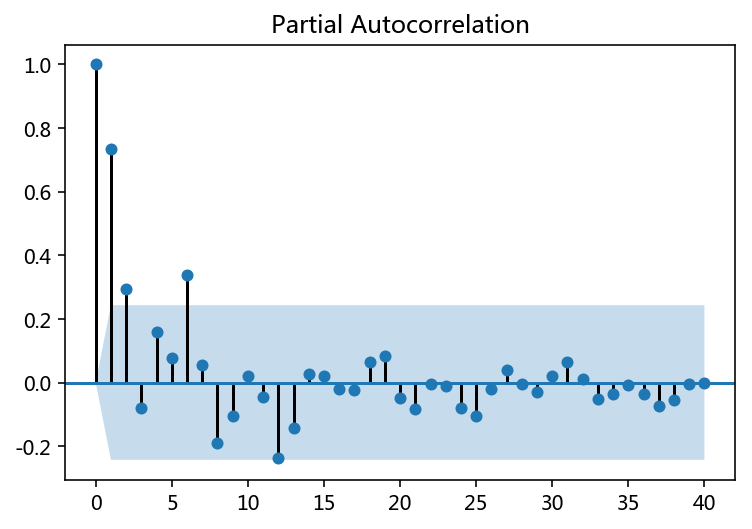

In [11]:
import statsmodels.api as sm
def acf_pacf_plot(ts_log_diff):
    sm.graphics.tsa.plot_acf(ts_log_diff,lags=40) #ARIMA,q
    sm.graphics.tsa.plot_pacf(ts_log_diff,lags=40) #ARIMA,p
acf_pacf_plot(ts.dropna()) #调用一阶差分

#### 方法2 通过借助AIC、BIC统计量自动确定

In [12]:
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(ts,max_ar=7,max_ma=7,ic=['aic', 'bic', 'hqic'])
order.bic_min_order

/Users/zhangle/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:443: RuntimeWarning: Inverting hessian failed, no bse or cov_params available
  warn(warndoc, RuntimeWarning)
/Users/zhangle/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/zhangle/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/zhangle/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/zhangle/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Chec

(1, 6)

#### build model

In [97]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts, order=(1,6,0))
result_arma = model.fit(disp=-1, method='css')

/Users/zhangle/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [98]:
train_predict = result_arma.predict()
RMSE = np.sqrt(((train_predict-ts)**2).sum()/ts.size)
RMSE

/Users/zhangle/anaconda3/lib/python3.6/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


174.48751384146587

In [99]:
predict_ts = result_arma.predict()

/Users/zhangle/anaconda3/lib/python3.6/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


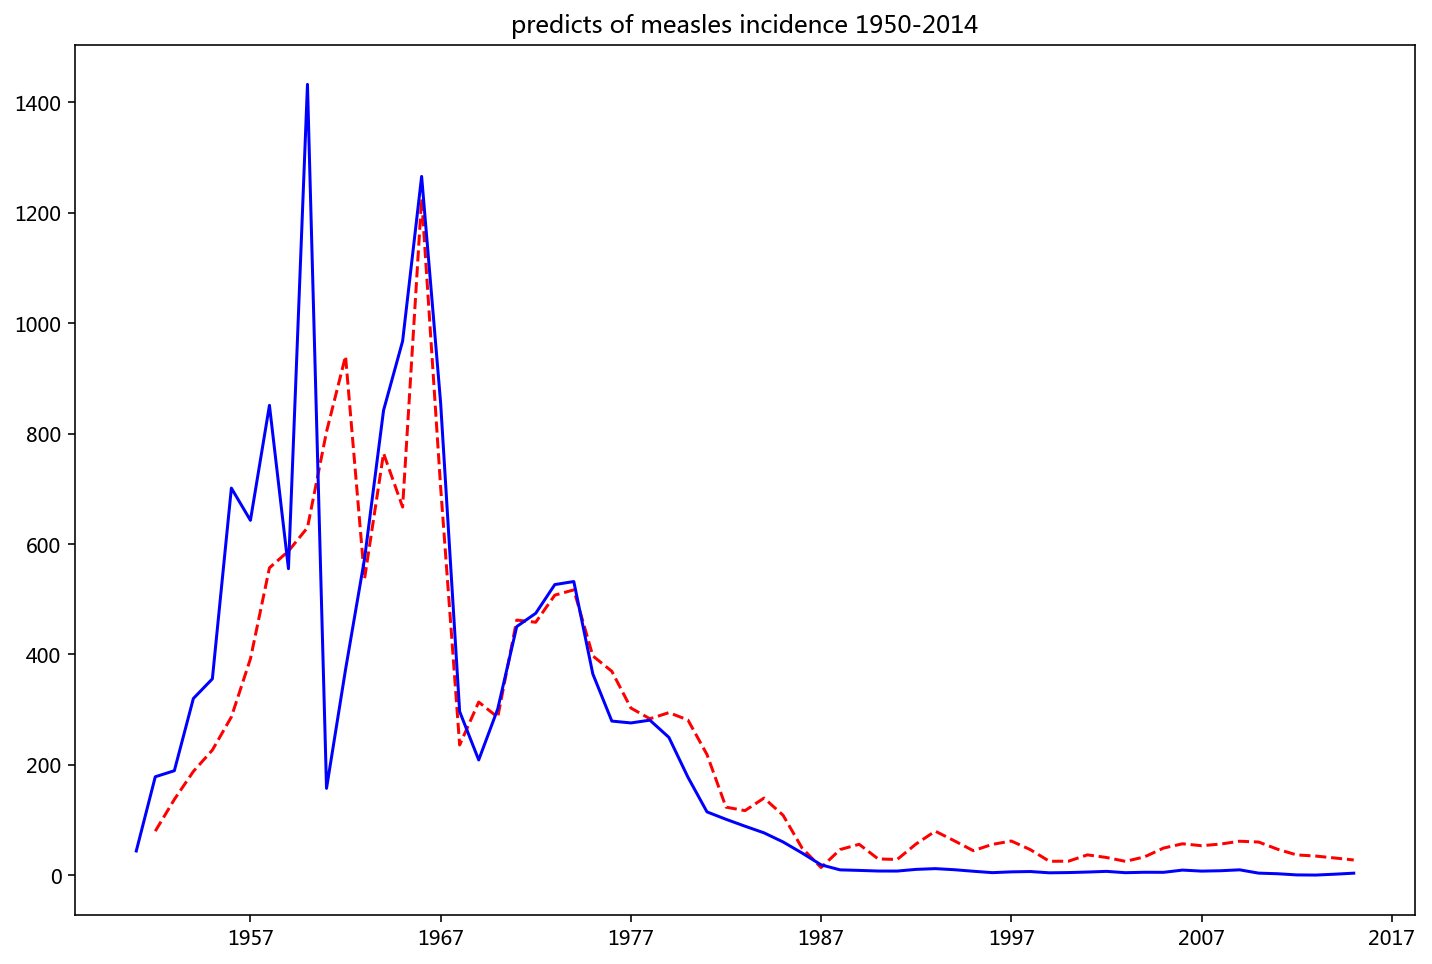

In [104]:
fig = plt.figure(figsize=(12,8)) 
plt.plot(predict_ts,'r--',ts,'b-')
plt.title('predicts of measles incidence 1950-2014')